# Description

(Please, take a look at the README.md file in this directory for instructions on how to run this notebook)

This notebook reads all gene correlations across all chromosomes and computes a single correlation matrix by assembling a big correlation matrix with all genes.

It has specicfic parameters for papermill (see under `Settings` below).

This notebook is not directly run. See README.md.

# Modules

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
from pathlib import Path

import numpy as np
from scipy.spatial.distance import squareform
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import conf
from entity import Gene
from correlations import (
    check_pos_def,
    compare_matrices,
    correct_corr_mat,
    adjust_non_pos_def,
)

# Settings

In [3]:
# a cohort name (it could be something like UK_BIOBANK, etc)
COHORT_NAME = None

# reference panel such as 1000G or GTEX_V8
REFERENCE_PANEL = "GTEX_V8"

# predictions models such as MASHR or ELASTIC_NET
EQTL_MODEL = "MASHR"

# output dir
OUTPUT_DIR_BASE = None

In [4]:
# Parameters
PHENOPLIER_NOTEBOOK_FILEPATH = "projects/asthma-copd/nbs/20_gene_corrs/jobs/10-postprocess_gene_expr_correlations.ipynb"
COHORT_NAME = "aco"
OUTPUT_DIR_BASE = "/opt/data/projects/asthma-copd/results/gls_phenoplier"


In [5]:
assert COHORT_NAME is not None and len(COHORT_NAME) > 0, "A cohort name must be given"

COHORT_NAME = COHORT_NAME.lower()
display(f"Cohort name: {COHORT_NAME}")

'Cohort name: aco'

In [6]:
assert (
    REFERENCE_PANEL is not None and len(REFERENCE_PANEL) > 0
), "A reference panel must be given"

display(f"Reference panel: {REFERENCE_PANEL}")

'Reference panel: GTEX_V8'

In [7]:
assert (
    EQTL_MODEL is not None and len(EQTL_MODEL) > 0
), "A prediction/eQTL model must be given"

display(f"eQTL model: {EQTL_MODEL})")

'eQTL model: MASHR)'

In [8]:
assert (
    OUTPUT_DIR_BASE is not None and len(OUTPUT_DIR_BASE) > 0
), "Output directory path must be given"

OUTPUT_DIR_BASE = (Path(OUTPUT_DIR_BASE) / "gene_corrs" / COHORT_NAME).resolve()

OUTPUT_DIR_BASE.mkdir(parents=True, exist_ok=True)

display(f"Using output dir base: {OUTPUT_DIR_BASE}")

'Using output dir base: /opt/data/projects/asthma-copd/results/gls_phenoplier/gene_corrs/aco'

In [9]:
INPUT_DIR = OUTPUT_DIR_BASE / "by_chr"

display(f"Gene correlations input dir: {INPUT_DIR}")
assert INPUT_DIR.exists()

'Gene correlations input dir: /opt/data/projects/asthma-copd/results/gls_phenoplier/gene_corrs/aco/by_chr'

# Load data

## Gene correlations

In [10]:
all_gene_corr_files = list(INPUT_DIR.glob("gene_corrs-chr*.pkl"))

In [11]:
# sort by chromosome
all_gene_corr_files = sorted(
    all_gene_corr_files, key=lambda x: int(x.name.split("-chr")[1].split(".pkl")[0])
)

In [12]:
len(all_gene_corr_files)

22

In [13]:
all_gene_corr_files

[PosixPath('/opt/data/projects/asthma-copd/results/gls_phenoplier/gene_corrs/aco/by_chr/gene_corrs-chr1.pkl'),
 PosixPath('/opt/data/projects/asthma-copd/results/gls_phenoplier/gene_corrs/aco/by_chr/gene_corrs-chr2.pkl'),
 PosixPath('/opt/data/projects/asthma-copd/results/gls_phenoplier/gene_corrs/aco/by_chr/gene_corrs-chr3.pkl'),
 PosixPath('/opt/data/projects/asthma-copd/results/gls_phenoplier/gene_corrs/aco/by_chr/gene_corrs-chr4.pkl'),
 PosixPath('/opt/data/projects/asthma-copd/results/gls_phenoplier/gene_corrs/aco/by_chr/gene_corrs-chr5.pkl'),
 PosixPath('/opt/data/projects/asthma-copd/results/gls_phenoplier/gene_corrs/aco/by_chr/gene_corrs-chr6.pkl'),
 PosixPath('/opt/data/projects/asthma-copd/results/gls_phenoplier/gene_corrs/aco/by_chr/gene_corrs-chr7.pkl'),
 PosixPath('/opt/data/projects/asthma-copd/results/gls_phenoplier/gene_corrs/aco/by_chr/gene_corrs-chr8.pkl'),
 PosixPath('/opt/data/projects/asthma-copd/results/gls_phenoplier/gene_corrs/aco/by_chr/gene_corrs-chr9.pkl'),
 

In [14]:
assert len(all_gene_corr_files) == 22

## Get common genes

In [15]:
gene_ids = set()
for f in all_gene_corr_files:
    chr_genes = pd.read_pickle(f).index.tolist()
    gene_ids.update(chr_genes)

In [16]:
display(len(gene_ids))

6442

In [17]:
sorted(list(gene_ids))[:5]

['ENSG00000000419',
 'ENSG00000000938',
 'ENSG00000000971',
 'ENSG00000001084',
 'ENSG00000001167']

## Gene info

In [18]:
genes_info = pd.read_pickle(OUTPUT_DIR_BASE / "genes_info.pkl")

In [19]:
genes_info.shape

(6442, 7)

In [20]:
genes_info.head()

,name,id,chr,band,start_position,end_position,gene_length
0,ASPM,ENSG00000066279,1,1q31.3,197084127,197146694,62567
1,GPAM,ENSG00000119927,10,10q25.2,112149865,112215377,65512
2,MAPK7,ENSG00000166484,17,17p11.2,19377721,19383544,5823
3,SLC3A2,ENSG00000168003,11,11q12.3,62856102,62888875,32773
4,GINS2,ENSG00000131153,16,16q24.1,85676198,85690073,13875


In [21]:
# keep genes in correlation matrices only
genes_info = genes_info[genes_info["id"].isin(gene_ids)]

In [22]:
genes_info.shape

(6442, 7)

In [23]:
assert not genes_info.isna().any(axis=None)

In [24]:
genes_info.dtypes

name              object
id                object
chr                 int8
band              object
start_position     int64
end_position       int64
gene_length        int64
dtype: object

In [25]:
genes_info.head()

,name,id,chr,band,start_position,end_position,gene_length
0,ASPM,ENSG00000066279,1,1q31.3,197084127,197146694,62567
1,GPAM,ENSG00000119927,10,10q25.2,112149865,112215377,65512
2,MAPK7,ENSG00000166484,17,17p11.2,19377721,19383544,5823
3,SLC3A2,ENSG00000168003,11,11q12.3,62856102,62888875,32773
4,GINS2,ENSG00000131153,16,16q24.1,85676198,85690073,13875


# Create full correlation matrix

In [26]:
genes_info = genes_info.sort_values(["chr", "start_position"])

In [27]:
genes_info

,name,id,chr,band,start_position,end_position,gene_length
2619,NOC2L,ENSG00000188976,1,1p36.33,944203,959309,15106
2992,HES4,ENSG00000188290,1,1p36.33,998962,1000172,1210
3567,ISG15,ENSG00000187608,1,1p36.33,1001138,1014540,13402
2722,AGRN,ENSG00000188157,1,1p36.33,1020120,1056118,35998
3344,TNFRSF18,ENSG00000186891,1,1p36.33,1203508,1206592,3084
...,...,...,...,...,...,...,...
798,CPT1B,ENSG00000205560,22,22q13.33,50568861,50578465,9604
2420,CHKB,ENSG00000100288,22,22q13.33,50578949,50601455,22506
4616,MAPK8IP2,ENSG00000008735,22,22q13.33,50600793,50613981,13188
4329,ARSA,ENSG00000100299,22,22q13.33,50622754,50628173,5419


In [28]:
full_corr_matrix = pd.DataFrame(
    np.zeros((genes_info.shape[0], genes_info.shape[0])),
    index=genes_info["id"].tolist(),
    columns=genes_info["id"].tolist(),
)

In [29]:
assert full_corr_matrix.index.is_unique & full_corr_matrix.columns.is_unique

In [30]:
for chr_corr_file in all_gene_corr_files:
    print(chr_corr_file.name, flush=True, end="... ")

    # get correlation matrix for this chromosome
    corr_data = pd.read_pickle(chr_corr_file)

    # save gene correlation matrix
    full_corr_matrix.loc[corr_data.index, corr_data.columns] = corr_data

    # save inverse of Cholesky decomposition of gene correlation matrix
    # first, adjust correlation matrix if it is not positive definite
    is_pos_def = check_pos_def(corr_data)

    if is_pos_def:
        print("all good.", flush=True, end="\n")
    else:
        print("not positive definite, fixing... ", flush=True, end="")
        corr_data_adjusted = adjust_non_pos_def(corr_data)

        is_pos_def = check_pos_def(corr_data_adjusted)
        assert is_pos_def, "Could not adjust gene correlation matrix"

        print("fixed! comparing...", flush=True, end="\n")
        compare_matrices(corr_data, corr_data_adjusted)

        corr_data = corr_data_adjusted

        # save
        full_corr_matrix.loc[corr_data.index, corr_data.columns] = corr_data

    print("\n")

gene_corrs-chr1.pkl... 

'Number of negative eigenvalues: 0'

'Negative eigenvalues:\n[]'

Works! (statsmodels.GLS)
Works!
all good.


gene_corrs-chr2.pkl... 

'Number of negative eigenvalues: 0'

'Negative eigenvalues:\n[]'

Works! (statsmodels.GLS)
Works!
all good.


gene_corrs-chr3.pkl... 

'Number of negative eigenvalues: 0'

'Negative eigenvalues:\n[]'

Works! (statsmodels.GLS)
Works!
all good.


gene_corrs-chr4.pkl... 

'Number of negative eigenvalues: 0'

'Negative eigenvalues:\n[]'

Works! (statsmodels.GLS)
Works!
all good.


gene_corrs-chr5.pkl... 

'Number of negative eigenvalues: 0'

'Negative eigenvalues:\n[]'

Works! (statsmodels.GLS)
Works!
all good.


gene_corrs-chr6.pkl... 

'Number of negative eigenvalues: 0'

'Negative eigenvalues:\n[]'

Works! (statsmodels.GLS)
Works!
all good.


gene_corrs-chr7.pkl... 

'Number of negative eigenvalues: 0'

'Negative eigenvalues:\n[]'

Works! (statsmodels.GLS)
Works!
all good.


gene_corrs-chr8.pkl... 

'Number of negative eigenvalues: 0'

'Negative eigenvalues:\n[]'

Works! (statsmodels.GLS)
Works!
all good.


gene_corrs-chr9.pkl... 

'Number of negative eigenvalues: 0'

'Negative eigenvalues:\n[]'

Works! (statsmodels.GLS)
Works!
all good.


gene_corrs-chr10.pkl... 

'Number of negative eigenvalues: 0'

'Negative eigenvalues:\n[]'

Works! (statsmodels.GLS)
Works!
all good.


gene_corrs-chr11.pkl... 

'Number of negative eigenvalues: 0'

'Negative eigenvalues:\n[]'

Works! (statsmodels.GLS)
Works!
all good.


gene_corrs-chr12.pkl... 

'Number of negative eigenvalues: 0'

'Negative eigenvalues:\n[]'

Cholesky decomposition failed (statsmodels.GLS): Matrix is not positive definite
Cholesky decomposition failed: Matrix is not positive definite
not positive definite, fixing... 

'Number of negative eigenvalues: 0'

'Negative eigenvalues:\n[]'

Works! (statsmodels.GLS)
Works!
fixed! comparing...


count    1.505440e+05
mean     1.351593e-18
std      1.658494e-16
min     -5.329071e-15
25%     -4.328044e-17
50%      2.499816e-19
75%      4.463927e-17
max      4.884981e-15
dtype: float64

ENSG00000151233  ENSG00000151233   -5.329071e-15
ENSG00000170456  ENSG00000170456   -4.440892e-15
ENSG00000184047  ENSG00000184047   -4.218847e-15
ENSG00000084463  ENSG00000084463   -3.774758e-15
ENSG00000029153  ENSG00000029153   -3.330669e-15
                                        ...     
ENSG00000075188  ENSG00000075188    3.774758e-15
ENSG00000111321  ENSG00000111321    3.996803e-15
ENSG00000089022  ENSG00000089022    4.440892e-15
ENSG00000167272  ENSG00000167272    4.662937e-15
ENSG00000139344  ENSG00000139344    4.884981e-15
Length: 150544, dtype: float64



gene_corrs-chr13.pkl... 

'Number of negative eigenvalues: 0'

'Negative eigenvalues:\n[]'

Works! (statsmodels.GLS)
Works!
all good.


gene_corrs-chr14.pkl... 

'Number of negative eigenvalues: 0'

'Negative eigenvalues:\n[]'

Works! (statsmodels.GLS)
Works!
all good.


gene_corrs-chr15.pkl... 

'Number of negative eigenvalues: 0'

'Negative eigenvalues:\n[]'

Works! (statsmodels.GLS)
Works!
all good.


gene_corrs-chr16.pkl... 

'Number of negative eigenvalues: 0'

'Negative eigenvalues:\n[]'

Works! (statsmodels.GLS)
Works!
all good.


gene_corrs-chr17.pkl... 

'Number of negative eigenvalues: 0'

'Negative eigenvalues:\n[]'

Works! (statsmodels.GLS)
Works!
all good.


gene_corrs-chr18.pkl... 

'Number of negative eigenvalues: 0'

'Negative eigenvalues:\n[]'

Works! (statsmodels.GLS)
Works!
all good.


gene_corrs-chr19.pkl... 

'Number of negative eigenvalues: 0'

'Negative eigenvalues:\n[]'

Works! (statsmodels.GLS)
Works!
all good.


gene_corrs-chr20.pkl... 

'Number of negative eigenvalues: 0'

'Negative eigenvalues:\n[]'

Works! (statsmodels.GLS)
Works!
all good.


gene_corrs-chr21.pkl... 

'Number of negative eigenvalues: 0'

'Negative eigenvalues:\n[]'

Works! (statsmodels.GLS)
Works!
all good.


gene_corrs-chr22.pkl... 

'Number of negative eigenvalues: 0'

'Negative eigenvalues:\n[]'

Works! (statsmodels.GLS)
Works!
all good.




In [31]:
full_corr_matrix.shape

(6442, 6442)

In [32]:
full_corr_matrix.head()

,ENSG00000188976,ENSG00000188290,ENSG00000187608,ENSG00000188157,ENSG00000186891,ENSG00000186827,ENSG00000176022,ENSG00000160087,ENSG00000131584,ENSG00000169962,...,ENSG00000196576,ENSG00000128165,ENSG00000100253,ENSG00000130489,ENSG00000025708,ENSG00000205560,ENSG00000100288,ENSG00000008735,ENSG00000100299,ENSG00000251322
ENSG00000188976,1.000000,0.120590,0.177063,0.085746,0.006792,0.007685,0.004673,0.010734,0.011200,0.007529,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000188290,0.120590,1.000000,0.672060,0.391127,0.011695,0.009275,0.005970,0.007385,0.002641,0.004767,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000187608,0.177063,0.672060,1.000000,0.424696,0.013929,0.013311,0.008466,0.010608,0.006689,0.011659,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000188157,0.085746,0.391127,0.424696,1.000000,0.005309,0.011848,0.002161,0.002535,0.005359,0.007012,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000186891,0.006792,0.011695,0.013929,0.005309,1.000000,0.338085,0.550817,0.154394,0.193627,0.101004,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
np.all(full_corr_matrix.to_numpy().diagonal() == 1.0)

False

## Some checks

In [34]:
_min_val = full_corr_matrix.min().min()
display(_min_val)
# assert _min_val >= -0.05

-1.8102381572904225e-15

In [35]:
_max_val = full_corr_matrix.max().max()
display(_max_val)
# assert _max_val <= 1.05

1.0000000000000044

## Positive definiteness

In some cases, even if the submatrices are adjusted, the whole one is not.

So here I check that again.

In [36]:
is_pos_def = check_pos_def(full_corr_matrix)

if is_pos_def:
    print("all good.", flush=True, end="\n")
else:
    print("not positive definite, fixing... ", flush=True, end="")
    corr_data_adjusted = adjust_non_pos_def(full_corr_matrix)

    is_pos_def = check_pos_def(corr_data_adjusted)
    assert is_pos_def, "Could not adjust gene correlation matrix"

    print("fixed! comparing...", flush=True, end="\n")
    compare_matrices(full_corr_matrix, corr_data_adjusted)

    full_corr_matrix = corr_data_adjusted

'Number of negative eigenvalues: 0'

'Negative eigenvalues:\n[]'

Works! (statsmodels.GLS)
Works!
all good.


## Save

### Gene corrs with gene symbols

In [37]:
output_file = OUTPUT_DIR_BASE / "gene_corrs-symbols.pkl"
display(output_file)

PosixPath('/opt/data/projects/asthma-copd/results/gls_phenoplier/gene_corrs/aco/gene_corrs-symbols.pkl')

In [38]:
gene_corrs = full_corr_matrix.rename(
    index=Gene.GENE_ID_TO_NAME_MAP, columns=Gene.GENE_ID_TO_NAME_MAP
)

In [39]:
assert not gene_corrs.isna().any(axis=None)
assert not np.isinf(gene_corrs.to_numpy()).any()
assert not np.iscomplex(gene_corrs.to_numpy()).any()

In [40]:
assert gene_corrs.index.is_unique
assert gene_corrs.columns.is_unique

In [41]:
gene_corrs.shape

(6442, 6442)

In [42]:
gene_corrs.head()

,NOC2L,HES4,ISG15,AGRN,TNFRSF18,TNFRSF4,B3GALT6,UBE2J2,ACAP3,TAS1R3,...,PLXNB2,ADM2,MIOX,SCO2,TYMP,CPT1B,CHKB,MAPK8IP2,ARSA,SHANK3
NOC2L,1.000000,0.120590,0.177063,0.085746,0.006792,0.007685,0.004673,0.010734,0.011200,0.007529,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HES4,0.120590,1.000000,0.672060,0.391127,0.011695,0.009275,0.005970,0.007385,0.002641,0.004767,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ISG15,0.177063,0.672060,1.000000,0.424696,0.013929,0.013311,0.008466,0.010608,0.006689,0.011659,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AGRN,0.085746,0.391127,0.424696,1.000000,0.005309,0.011848,0.002161,0.002535,0.005359,0.007012,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TNFRSF18,0.006792,0.011695,0.013929,0.005309,1.000000,0.338085,0.550817,0.154394,0.193627,0.101004,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
gene_corrs.to_pickle(output_file)

In [44]:
del gene_corrs

# Stats

In [45]:
full_corr_matrix_flat = full_corr_matrix.mask(
    np.triu(np.ones(full_corr_matrix.shape)).astype(bool)
).stack()

In [46]:
display(full_corr_matrix_flat.shape)
assert full_corr_matrix_flat.shape[0] == int(
    full_corr_matrix.shape[0] * (full_corr_matrix.shape[0] - 1) / 2
)

(20746461,)

## On all correlations

In [47]:
_corr_mat = full_corr_matrix_flat

In [48]:
_corr_mat.shape

(20746461,)

In [49]:
_corr_mat.head()

ENSG00000188290  ENSG00000188976    0.120590
ENSG00000187608  ENSG00000188976    0.177063
                 ENSG00000188290    0.672060
ENSG00000188157  ENSG00000188976    0.085746
                 ENSG00000188290    0.391127
dtype: float64

In [50]:
_corr_mat.describe().apply(str)

count                20746461.0
mean     0.00016513466798933398
std         0.00689074778429947
min      -1.809370795552434e-15
25%                         0.0
50%                         0.0
75%                         0.0
max          0.9999999999999993
dtype: object

In [51]:
display(_corr_mat.quantile(np.arange(0, 1, 0.05)))

0.00   -1.809371e-15
0.05    0.000000e+00
0.10    0.000000e+00
0.15    0.000000e+00
0.20    0.000000e+00
0.25    0.000000e+00
0.30    0.000000e+00
0.35    0.000000e+00
0.40    0.000000e+00
0.45    0.000000e+00
0.50    0.000000e+00
0.55    0.000000e+00
0.60    0.000000e+00
0.65    0.000000e+00
0.70    0.000000e+00
0.75    0.000000e+00
0.80    0.000000e+00
0.85    0.000000e+00
0.90    0.000000e+00
0.95    0.000000e+00
dtype: float64

In [52]:
display(_corr_mat.quantile(np.arange(0, 0.001, 0.0001)))

0.0000   -1.809371e-15
0.0001   -2.091527e-16
0.0002   -1.468529e-16
0.0003   -1.138790e-16
0.0004   -9.113829e-17
0.0005   -7.395414e-17
0.0006   -6.003579e-17
0.0007   -4.858802e-17
0.0008   -3.876427e-17
0.0009   -3.047111e-17
dtype: float64

In [53]:
display(_corr_mat.quantile(np.arange(0.999, 1.0, 0.0001)))

0.9990    0.014695
0.9991    0.016644
0.9992    0.020192
0.9993    0.026096
0.9994    0.034876
0.9995    0.050378
0.9996    0.078848
0.9997    0.132079
0.9998    0.234434
0.9999    0.396340
1.0000    1.000000
dtype: float64

### Plot: distribution

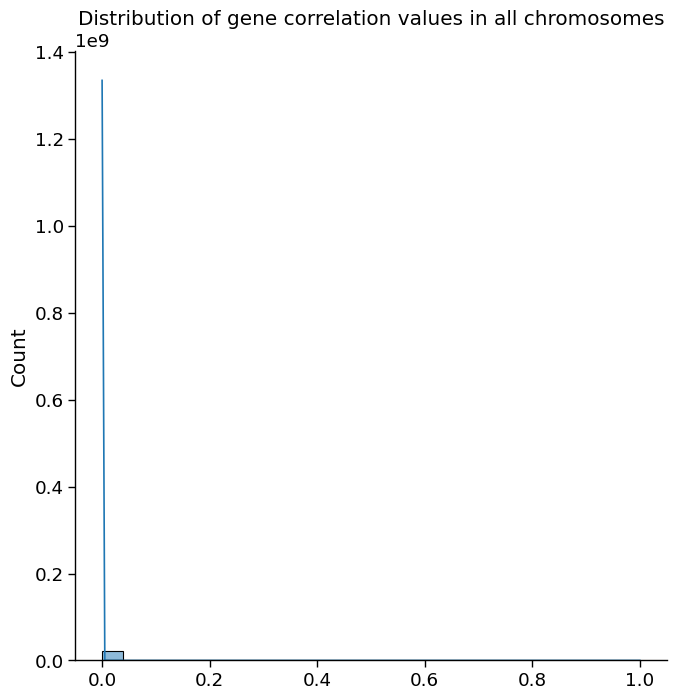

In [54]:
with sns.plotting_context("paper", font_scale=1.5):
    g = sns.displot(_corr_mat, kde=True, height=7)
    g.ax.set_title("Distribution of gene correlation values in all chromosomes")

### Plot: heatmap

In [55]:
vmin_val = 0.0
vmax_val = max(0.05, _corr_mat.quantile(0.99))
display(f"{vmin_val} / {vmax_val}")

'0.0 / 0.05'

Text(0.5, 1.0, 'Gene correlations in all chromosomes')

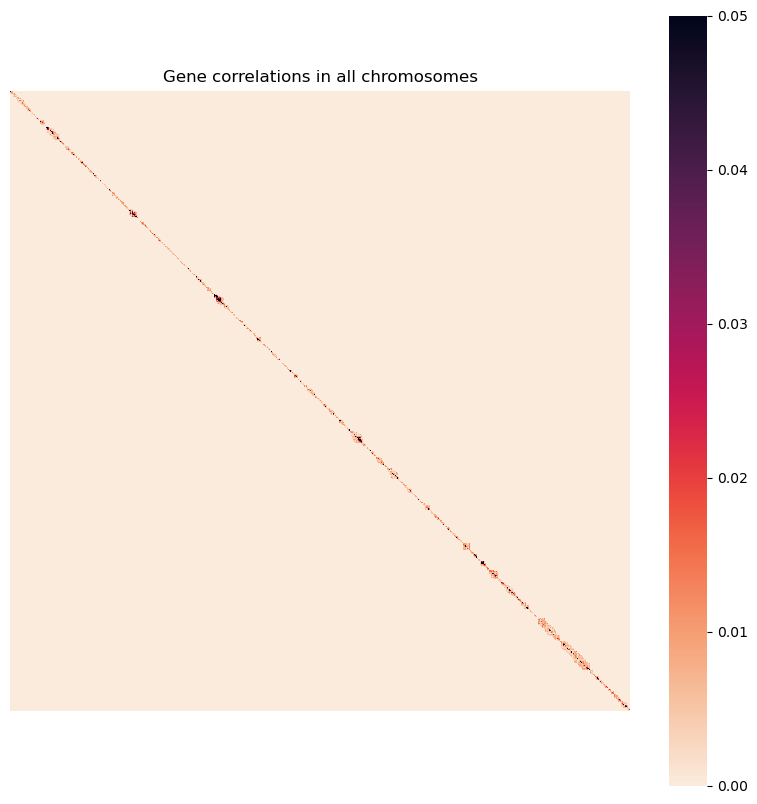

In [56]:
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(
    full_corr_matrix,
    xticklabels=False,
    yticklabels=False,
    square=True,
    vmin=vmin_val,
    vmax=vmax_val,
    cmap="rocket_r",
    ax=ax,
)
ax.set_title("Gene correlations in all chromosomes")

## On nonzero correlations

In [57]:
nonzero_corrs = full_corr_matrix_flat[full_corr_matrix_flat > 0.0]

In [58]:
_corr_mat = nonzero_corrs

In [59]:
_corr_mat.shape

(160593,)

In [60]:
_corr_mat.head()

ENSG00000188290  ENSG00000188976    0.120590
ENSG00000187608  ENSG00000188976    0.177063
                 ENSG00000188290    0.672060
ENSG00000188157  ENSG00000188976    0.085746
                 ENSG00000188290    0.391127
dtype: float64

In [61]:
_corr_mat.describe().apply(str)

count                  160593.0
mean       0.021333183570819887
std         0.07538264320512299
min      2.9518609641795857e-22
25%       0.0016897934005945293
50%        0.005381889862207424
75%          0.0091992655652382
max          0.9999999999999993
dtype: object

In [62]:
display(_corr_mat.quantile(np.arange(0, 1, 0.05)))

0.00    2.951861e-22
0.05    1.213023e-17
0.10    3.713782e-17
0.15    8.522270e-17
0.20    3.095846e-16
0.25    1.689793e-03
0.30    2.659276e-03
0.35    3.447663e-03
0.40    4.125627e-03
0.45    4.749444e-03
0.50    5.381890e-03
0.55    6.014568e-03
0.60    6.679910e-03
0.65    7.400380e-03
0.70    8.212383e-03
0.75    9.199266e-03
0.80    1.054871e-02
0.85    1.284110e-02
0.90    2.147009e-02
0.95    8.380892e-02
dtype: float64

In [63]:
display(_corr_mat.quantile(np.arange(0, 0.001, 0.0001)))

0.0000    2.951861e-22
0.0001    1.113314e-20
0.0002    2.048910e-20
0.0003    3.706755e-20
0.0004    5.035472e-20
0.0005    6.637771e-20
0.0006    8.322568e-20
0.0007    9.311173e-20
0.0008    1.165452e-19
0.0009    1.258892e-19
dtype: float64

In [64]:
display(_corr_mat.quantile(np.arange(0.999, 1.0, 0.0001)))

0.9990    0.769709
0.9991    0.784967
0.9992    0.793754
0.9993    0.805009
0.9994    0.828017
0.9995    0.860502
0.9996    0.893454
0.9997    0.933690
0.9998    0.960322
0.9999    0.984813
1.0000    1.000000
dtype: float64

### Plot: distribution

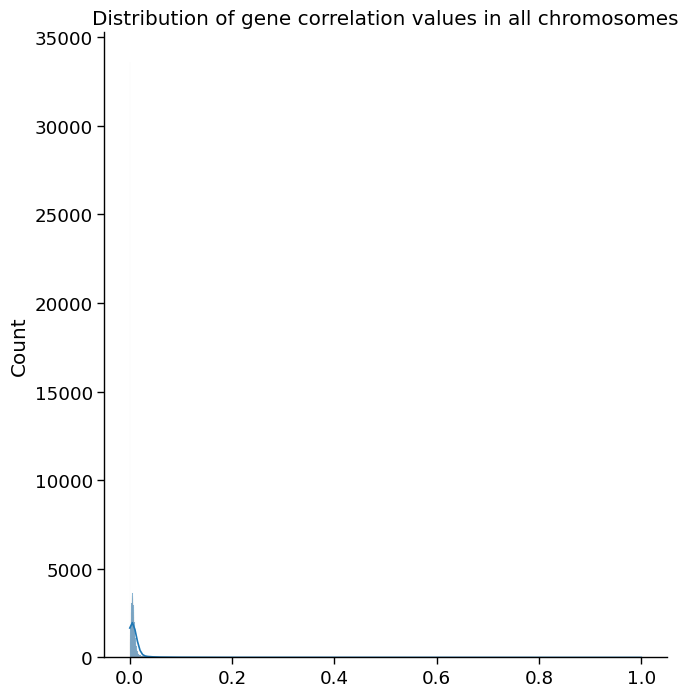

In [65]:
with sns.plotting_context("paper", font_scale=1.5):
    g = sns.displot(_corr_mat, kde=True, height=7)
    g.ax.set_title("Distribution of gene correlation values in all chromosomes")